In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, initializers
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator



*Loading Dataset*

In [ ]:
#batch_size = 64 

#img_height = 256
#img_width =  256
batch_size = 16 

img_height = 224
img_width =  224

data_dir = '/content/drive/MyDrive/paddy disease/train_images'

In [ ]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                            rescale=1.0/255.0,
                            validation_split=0.3,
                            rotation_range=5,
                            shear_range=0.3,
                            zoom_range=0.4,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True
                )

In [ ]:
train_data = '/content/drive/MyDrive/paddy disease/test_images'

In [ ]:
train_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="training",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical",
                            color_mode='rgb'
            )

Found 7288 images belonging to 10 classes.


In [ ]:
test_data = '/content/drive/MyDrive/data2/test_image'

In [ ]:
test_gen = img_datagen.flow_from_directory(
                            data_dir,
                            subset="validation",
                            seed=42,
                            target_size=(img_height, img_width),
                            batch_size=batch_size,
                            class_mode="categorical"
            )

Found 3119 images belonging to 10 classes.


In [ ]:
print('Total No Of Classes in the datasetL:',len(train_gen.class_indices))
print('Class Names:',train_gen.class_indices)

Total No Of Classes in the datasetL: 10
Class Names: {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}


In [ ]:
#cnn model

In [ ]:
num_classes = 10
input_shape = (1,224,224,3)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [224, 224,3]),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (2, 2), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 27, 27, 64)       0

In [ ]:
class TerminateNaN(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    loss = logs.get('loss')
    if loss is not None:
      if np.isnan(loss) or np.isinf(loss):
        print('Invalid loss and terminated at loss {}'.format(epoch))
        self.model.stop_training = True

terminate_nan = TerminateNaN()

In [ ]:
# save model after every epoch if the validation accuracy improves from previous epoch
filepath = '/content/drive/MyDrive/keras_model_new.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = filepath,
    monitor="val_categorical_accuracy",
    verbose=1,
    save_best_only=True,
    mode = 'auto'
)

In [ ]:
# learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.1,
    patience=1,
    verbose=1,
    mode="auto",
    min_delta=0.001,
    cooldown=3,
    min_lr=0
)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)]
)

In [ ]:
history = model.fit(
    train_gen,
    batch_size = batch_size,
    validation_data = test_gen,
    epochs=20,
    verbose=1,
    callbacks=[terminate_nan, checkpoint, reduce_lr]
)

Epoch 1/20
456/456 [==============================] - ETA: 0s - loss: 1.9999 - categorical_accuracy: 0.2818
Epoch 1: val_categorical_accuracy improved from -inf to 0.35717, saving model to /content/drive/MyDrive/keras_model_new.h5
456/456 [==============================] - 3854s 8s/step - loss: 1.9999 - categorical_accuracy: 0.2818 - val_loss: 1.8293 - val_categorical_accuracy: 0.3572 - lr: 3.0000e-04
Epoch 2/20
456/456 [==============================] - ETA: 0s - loss: 1.7415 - categorical_accuracy: 0.3945
Epoch 2: val_categorical_accuracy improved from 0.35717 to 0.41263, saving model to /content/drive/MyDrive/keras_model_new.h5
456/456 [==============================] - 794s 2s/step - loss: 1.7415 - categorical_accuracy: 0.3945 - val_loss: 1.7167 - val_categorical_accuracy: 0.4126 - lr: 3.0000e-04
Epoch 3/20
456/456 [==============================] - ETA: 0s - loss: 1.5766 - categorical_accuracy: 0.4487
Epoch 3: val_categorical_accuracy improved from 0.41263 to 0.45752, saving model

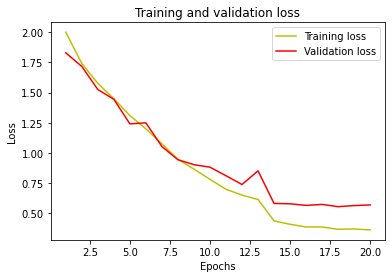

In [ ]:
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

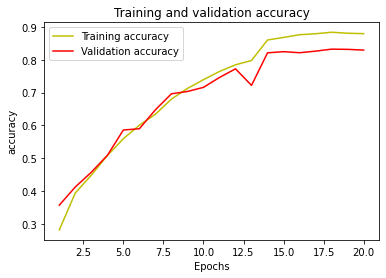

In [ ]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_gen)

195/195 [==============================] - 123s 627ms/step - loss: 0.5673 - categorical_accuracy: 0.8285


In [ ]:
print('Validation Accuracy', accuracy)

Validation Accuracy 0.8284706473350525


In [ ]:
predictions = model.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_gen.classes
class_names = list(test_gen.class_indices.keys())

195/195 [==============================] - 114s 580ms/step


In [ ]:
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

[[  6   3   9  28  13  21   9  17  27  10]
 [  6   5   4  20  12  13   5  19  22   8]
 [  2   5   4  16   6  12   2  18  25  11]
 [ 22  16  20  81  41  82  23  73 106  57]
 [ 11  11   7  61  27  36  18  36  48  34]
 [ 12  20  12  73  41  65  20  66  78  45]
 [  5   5   5  54  17  23   4  31  25  17]
 [ 16  13  14  77  47  65  27  96  76  47]
 [ 27  23  15  80  47  60  31  86 103  57]
 [ 14  12  13  59  37  44  17  45  54  31]]


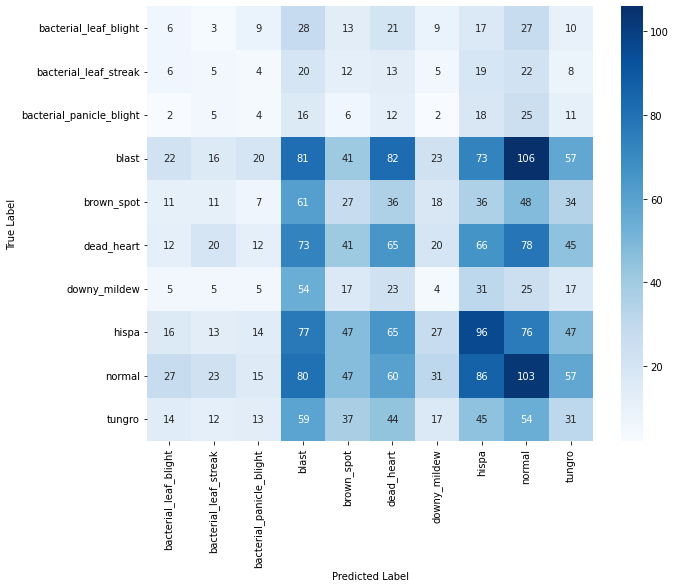

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(true_labels, predicted_labels)
print('\nClassification Report:\n', cr)


Classification Report:
               precision    recall  f1-score   support

           0       0.05      0.04      0.05       143
           1       0.04      0.04      0.04       114
           2       0.04      0.04      0.04       101
           3       0.15      0.16      0.15       521
           4       0.09      0.09      0.09       289
           5       0.15      0.15      0.15       432
           6       0.03      0.02      0.02       186
           7       0.20      0.20      0.20       478
           8       0.18      0.19      0.19       529
           9       0.10      0.10      0.10       326

    accuracy                           0.14      3119
   macro avg       0.10      0.10      0.10      3119
weighted avg       0.13      0.14      0.13      3119

